In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.stats import linregress
import numpy.ma as ma
import cartopy.crs as ccrs
from tqdm.notebook import tqdm as tqdm
import glob

#import mplotutils as mpu
import cf_units
import cftime

In [2]:
##Getting nan mask from Knutson's dataset (stays the same for our time period)

df_1951_2010=xr.open_dataset('data/9cat.195101-201012.nc').roll(LON=72, roll_coords=True)
arr_1951_2010=np.full([72, 144],np.nan)

arr_1951_2010[(df_1951_2010.CP4.values==4).reshape(72, 144)]=3
arr_1951_2010[(df_1951_2010.CP3.values==3).reshape(72, 144)]=3
arr_1951_2010[(df_1951_2010.CP2.values==2).reshape(72, 144)]=2
arr_1951_2010[(df_1951_2010.CP1.values==1).reshape(72, 144)]=1
arr_1951_2010[(df_1951_2010.CP0.values==0).reshape(72, 144)]=0
arr_1951_2010[(df_1951_2010.CM4.values==-4).reshape(72, 144)]=-3
arr_1951_2010[(df_1951_2010.CM3.values==-3).reshape(72, 144)]=-3
arr_1951_2010[(df_1951_2010.CM2.values==-2).reshape(72, 144)]=-2
arr_1951_2010[(df_1951_2010.CM1.values==-1).reshape(72, 144)]=-1

nan_mask_knut=np.isnan(arr_1951_2010)


In [3]:
##Loading GPCC precip Observational data

def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(72),np.arange(144))
    slope=np.zeros([72,144])
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        slope[i_x,i_y]=10*stats.linregress(np.arange(end-start+1),df[i_start:i_end+1,i_x,i_y])[0]
    return slope


df_gpcc=xr.open_mfdataset('data/precip.mon.total.2.5x2.5.v2018.nc').groupby('time.year').mean('time')
df_gpcc= df_gpcc.roll(lon=72).sortby('lat').assign_coords(lon= (((df_gpcc.lon + 180) % 360) - 180))
##lat is flipped for some reason

ref = 1951
trend_gpcc = {}
for year_idx in range(2000,2017):
        
    trend_gpcc[year_idx]=linregress_grid(df_gpcc.sel(year=slice(1870,2021)).precip.values,
                         df_gpcc.sel(year=slice(1870,2021)).year.values,ref,year_idx)
    trend_gpcc[year_idx][nan_mask_knut]=np.nan


In [4]:
# get model data

models=[
    'MIROC6', 
    'IPSL-CM6A-LR', 
    'CanESM5', 
    'HadGEM3-GC31-LL', 
    'CNRM-CM6-1', 
    'GFDL-ESM4', 
    'ACCESS-ESM1-5', 
    'BCC-CSM2-MR', 
    'NorESM2-LM', 
    'MRI-ESM2-0'
]
    
dir_var = '/home/sarah/projects/CVM3/data/models/pr/'
member = 'r*1p1f1'
gen = 6
obs = 'pr' # precipitation
time_res = 'ann'
period = 2016-1891

hist_name = 'historical'
ssp_name  ='ssp*' 
hn_name   = 'hist-nat'
pi_name   = 'piControl'

def get_run_nr(filename):
    run = filename.split('_')[-2]
    return run.split("i1p1f1")[0][1:]

y_af = {}
y_hn = {}
y_pi = {}

time_af={}
time_hn={}
time_pi={}


### get usable models
usable_models = []
for model in models:
    
    y_af[model] = {}
    y_hn[model] = {}
    y_pi[model] = {}
    
    time_af[model]=[]
    time_hn[model]=[]
    time_pi[model]=[]

    
    # example file: pr_ann_MIROC6_historical_r3i1p1f1_g025.nc
    hist_name_list=sorted(glob.glob(f'{dir_var}{model}/g025/{obs}_{time_res}_{model}_{hist_name}_{member}_g025.nc'))
    ssp_name_list=sorted(glob.glob(f'{dir_var}{model}/g025/{obs}_{time_res}_{model}_{ssp_name}_{member}_g025.nc'))
    hn_name_list=sorted(glob.glob(f'{dir_var}{model}/g025/{obs}_{time_res}_{model}_{hn_name}_{member}_g025.nc'))
    pi_name_list=sorted(glob.glob(f'{dir_var}{model}/g025/{obs}_{time_res}_{model}_{pi_name}_{member}_g025.nc'))
    
    for i, hist in enumerate(hist_name_list):
        run = get_run_nr(hist)
        # all forcing: combination of historical and projection of shared socioeconomic pathways
        i_ssp = i % (len(ssp_name_list))
        try: 
            data = xr.open_mfdataset([hist, ssp_name_list[i_ssp]],combine='nested', concat_dim='time').sel(time=slice('1891-01-01', '2017-01-01'))
            data = data.roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180)) # assign different coordinates
            y_af[model][run] = 2.628e+6*data.pr.values  # seconds in a month: 2.628e+6
            time_af[model].append(data.time)
        except:
            pass

    for hn in hn_name_list:
        run = get_run_nr(hn)
        data = xr.open_dataset(hn).sel(time=slice('1891-01-01', '2017-01-01'))
        data = data.roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180))
        y_hn[model][run] = 2.628e+6*data.pr.values
        time_hn[model].append(data.time)
        
    for pi in pi_name_list:
        run = get_run_nr(pi)
        data = xr.open_dataset(pi)
        data = data.roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180))
        y_pi[model][run] = 2.628e+6*data.pr.values
        time_pi[model].append(data.time)
        
      
    len_af=len(y_af[model])
    len_hn=len(y_hn[model])
    len_pi=len(y_pi[model])
    
    #models only usable if all-forcing run exists, at least 3 histNat runs exist and length of histNat is same as period under investigation
    diff_period_hn_time = [len(time) - period for time in time_hn[model] ]
    if len_af<1 or len_hn<3 or any(d < 0 for d in diff_period_hn_time):
        print('\nCannot use model data for', model)
        print(f'AF run number: {len_af}, time length of: {[len(time) for time in time_af[model] ]}')
        print(f'HN run number: {len_hn}, time length of: {[len(time) for time in time_hn[model] ]}')
        
    else:        
        print('\nGot model data for', model)
        usable_models.append(model)
        print(f'AF run number: {len(y_af[model])}, time length of: {[len(time) for time in time_af[model] ]}')
        print(f'HN run number: {len(y_hn[model])}, time length of: {[len(time) for time in time_hn[model] ]}')
        print(f'PI run number: {len(y_pi[model])}, time length of: {[len(time) for time in time_pi[model] ]}')

models = usable_models


/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Got model data for MIROC6
AF run number: 50, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number: 50, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
PI run number: 1, time length of: [800]


/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty


Got model data for IPSL-CM6A-LR
AF run number: 33, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number: 10, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
PI run number: 1, time length of: [2000]

Got model data for CanESM5
AF run number: 25, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number: 25, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
PI run number: 1, time length of: [1000]

Cannot use model data for HadGEM3-GC31-LL
AF run number: 0, time length of: []
HN run number: 0, time length of: []

Cannot use model data for CNRM-CM6-1
AF run number: 0, time length of: []
HN run number: 0, time length of: []

Got model data for

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Got model data for ACCESS-ESM1-5
AF run number: 40, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number: 3, time length of: [126, 126, 126]
PI run number: 1, time length of: [900]

Got model data for BCC-CSM2-MR
AF run number: 3, time length of: [126, 126, 126]
HN run number: 3, time length of: [126, 126, 126]
PI run number: 1, time length of: [600]

Got model data for NorESM2-LM
AF run number: 3, time length of: [126, 126, 126]
HN run number: 3, time length of: [126, 126, 126]
PI run number: 1, time length of: [391]


/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty


Got model data for MRI-ESM2-0
AF run number: 10, time length of: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number: 5, time length of: [126, 126, 126, 126, 126]
PI run number: 1, time length of: [701]


In [5]:
## Drift correct the models preindustrial control runs
y_pi_dc={}

for model in models:
    first_key = list(y_pi[model].keys())[0]
    if len(y_pi[model])>1:
        y_pi_temp=np.vstack(([y_pi[model][key] for key in y_pi[model].keys()]))
        y_pi_dc[model]=np.zeros_like(y_pi_temp)
    else:
        y_pi_dc[model]=np.zeros_like(y_pi[model][first_key])
        
    x,y=np.meshgrid(np.arange(y_pi[model][first_key].shape[1]),np.arange(y_pi[model][first_key].shape[2]))
    
    i_key=0
    for key in y_pi[model].keys():
        for i_x, i_y in zip(x.flatten(),y.flatten()):
            #print(i_x,i_y)
            slope, intercept,_,_,_=linregress(np.arange(y_pi[model][key].shape[0]),
                                              y_pi[model][key][:,i_x,i_y])
            drift=slope*np.arange(y_pi[model][key].shape[0])+intercept
            y_pi_dc[model][i_key:i_key+y_pi[model][key].shape[0],i_x,i_y]=y_pi[model][key][:,i_x,i_y]-drift
            
        i_key+=y_pi[model][key].shape[0]
        

In [6]:
##Calculate internal variability for smoothed observations (Smoothed using 7 year running mean)

y_af_all = np.stack(([y_af[model][key] for model in  y_pi_dc.keys() for key in y_af[model]]))

x,y = np.meshgrid(np.arange(72),np.arange(144))
#df_gpcc_detrend = df_gpcc.sel(year=slice('1891', '2016')).precip.values - np.mean(y_af_all,axis=0)
df_gpcc_detrend = df_gpcc.sel(year=slice('1891', '2016')).precip.values - np.mean(y_af_all,axis=0)

df_gpcc_detrend[np.isnan(df_gpcc_detrend)]=0

x,y=np.meshgrid(np.arange(df_gpcc_detrend.shape[1]),np.arange(df_gpcc_detrend.shape[2]))

output=np.zeros_like(df_gpcc_detrend)
for i_x,i_y in tqdm(zip(x.flatten(),y.flatten())):
    output[:,i_x,i_y] = np.convolve(df_gpcc_detrend[:,i_x,i_y].flatten(),np.ones(7)/7, mode='full')[:-6] ##moving window average

output=output[6:,:,:]#remove first and last half of moving window
output=output[:-6,:,:]
gpcc_var=np.nanstd(output,axis=0)
gpcc_var[nan_mask_knut]=np.nan

0it [00:00, ?it/s]

In [148]:
## function to calculate 7 year moving average

def butter(df):
    
    output=np.zeros_like(df)
    for i_x,i_y in zip(x.flatten(),y.flatten()):
        output[:,i_x,i_y] = np.convolve(df[:,i_x,i_y].flatten(),np.ones(7)/7, mode='full')[:-6]  
    output=output[6:,:,:]
    output=output[:-6,:,:]
    
    return output

/tmp/ipykernel_330576/395924253.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)


(0.0, 1.0, 0.0, 1.0)

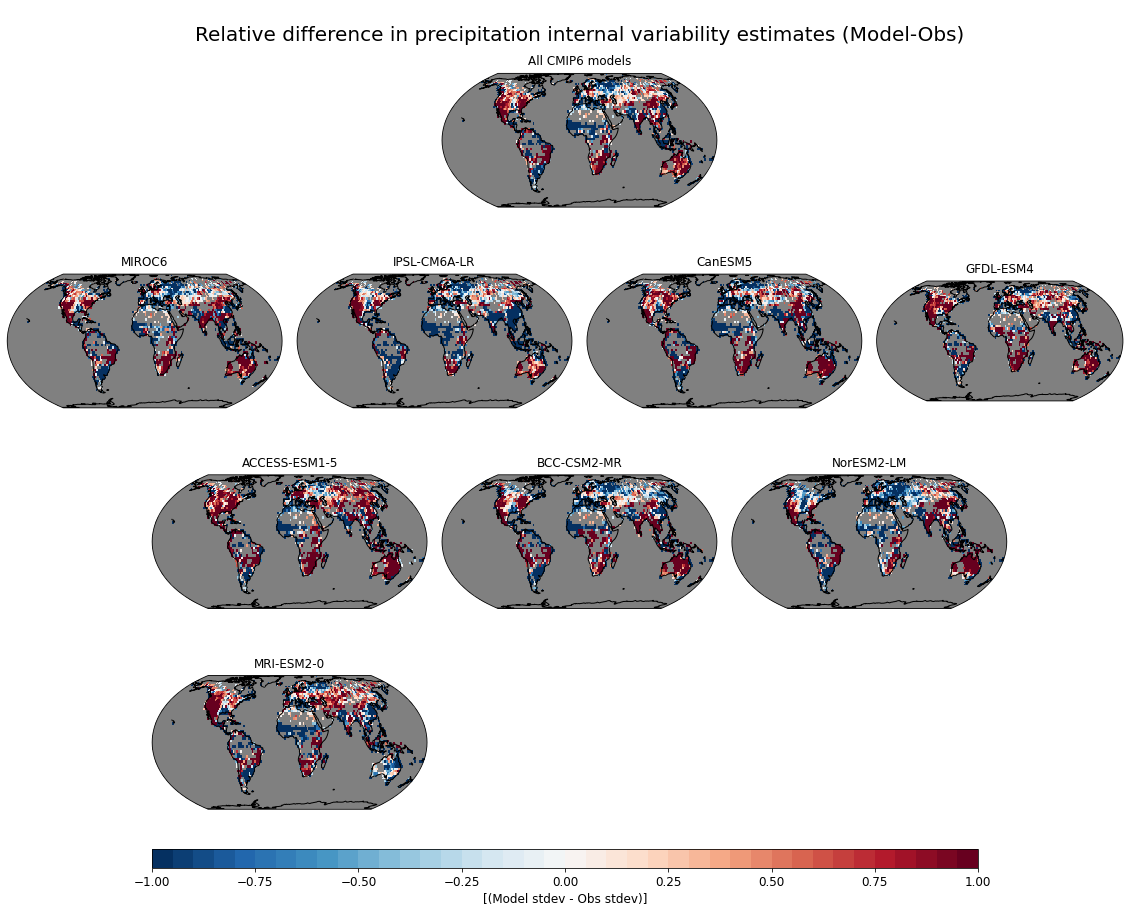

In [151]:
#plot difference in internal variability of smoothed model runs and smoothed observations
n_col = 4
n_row = 4

fig=plt.figure(figsize=(n_col*5, n_row * 4))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

degrees = 2.5
lon = np.linspace(-180+degrees*.5,180-degrees*.5,int(360/degrees))
lat = np.linspace(-90+degrees*.5,90-degrees*.5,int(180/degrees))

grid = plt.GridSpec(n_row*3+1, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

i=0
i_y=0

for i in range(len(models)+1):
    
    if i==0:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for model in y_pi.keys() for key in y_pi[model].keys()])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 

        ax = plt.subplot(grid[i+1:i+3,(i_y+1)*10+5:(i_y+1)*10+15], projection=ccrs.EqualEarth())
        
    elif i<5:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        ax = plt.subplot(grid[4:6,i_y*10:i_y*10+10], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
    
    elif i>4:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        
        if (i-5)%3==0:
            i_y=0
            ax = plt.subplot(grid[i+2:i+4,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))

        else:
            ax = plt.subplot(grid[(i-5)-((i-5)%3)+7:(i-5)-((i-5)%3)+9,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
        
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, (mod_pi_var-gpcc_var), transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r',40), vmin=-1, vmax=1,rasterized=True)
    if i==0:
        ax.set_title("All CMIP6 models",y=1.02,fontsize=12)
    else:
        ax.set_title(models[i-1],y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

axtitle = plt.subplot(grid[0,6:-5])
plt.title('Relative difference in precipitation internal variability estimates (Model-Obs)',fontsize=20,y=0.4)      
plt.axis('off') 

axcbar = plt.subplot(grid[-1:,5:-5])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('[(Model stdev - Obs stdev)]')  
plt.axis('off')

/tmp/ipykernel_330576/1255359917.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)


(0.0, 1.0, 0.0, 1.0)

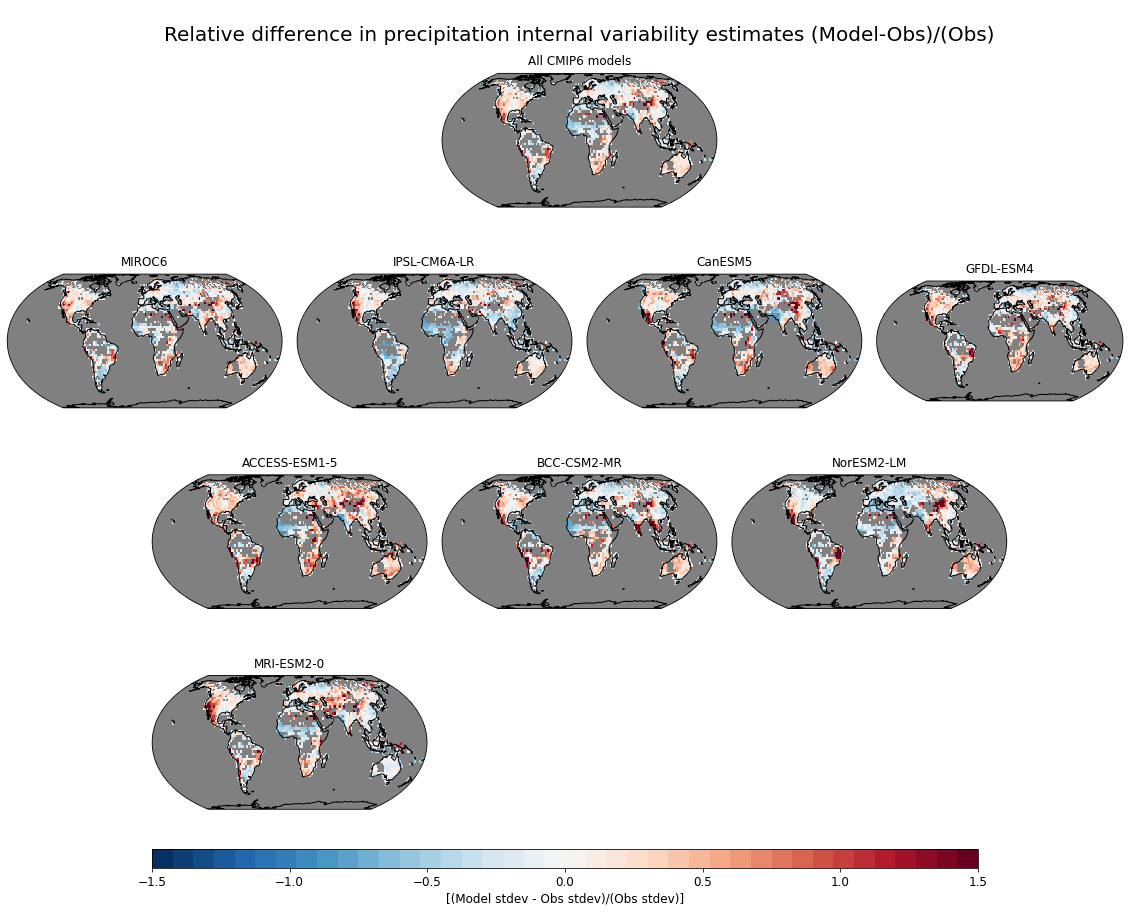

In [155]:
#plot difference in internal variability of smoothed model runs and smoothed observations 
## relative to smoothed observation internal variabilits
n_col = 4
n_row = 4

fig = plt.figure(figsize=(n_col*5, n_row * 4))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'})

degrees = 2.5
lon = np.linspace(-180+degrees*.5,180-degrees*.5,int(360/degrees))
lat = np.linspace(-90+degrees*.5,90-degrees*.5,int(180/degrees))

grid = plt.GridSpec(n_row*3+1, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

i=0
i_y=0

for i in range(len(models)+1):
    
    if i==0:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for model in y_pi.keys() for key in y_pi[model].keys()])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 

        ax = plt.subplot(grid[i+1:i+3,(i_y+1)*10+5:(i_y+1)*10+15], projection=ccrs.EqualEarth())
        
    elif i<5:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        ax = plt.subplot(grid[4:6,i_y*10:i_y*10+10], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
    
    elif i>4:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        
        if (i-5)%3==0:
            i_y=0
            ax = plt.subplot(grid[i+2:i+4,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))

        else:
            ax = plt.subplot(grid[(i-5)-((i-5)%3)+7:(i-5)-((i-5)%3)+9,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
        
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, (mod_pi_var-gpcc_var)/gpcc_var, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r',40), vmin=-1.5, vmax=1.5,rasterized=True)
    if i==0:
        ax.set_title("All CMIP6 models",y=1.02,fontsize=12)
    else:
        ax.set_title(models[i-1],y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

axtitle = plt.subplot(grid[0,6:-5])
plt.title('Relative difference in precipitation internal variability estimates (Model-Obs)/(Obs)',fontsize=20,y=0.4)      
plt.axis('off') 

axcbar = plt.subplot(grid[-1:,5:-5])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('[(Model stdev - Obs stdev)/(Obs stdev)]')  
plt.axis('off') 

In [156]:
def mean_trend_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.mean(all_trends,axis=0),72,1)
    else:
        return np.mean(all_trends,axis=0)


#create trend distributions for all-forcing and natural-forcing runs by resampling variability 
#from piControl runs
trend_hn = {}
trend_af = {}
resampled_trend_hn = {}
resampled_trend_af = {}
time={}

n_samples=50
obs_std=gpcc_var
ref_year = 1951

for model in models:
    time[model]=np.arange(1891,2017)
    trend_hn[model]={}
    trend_af[model]={}
    resampled_trend_hn[model] = {}
    resampled_trend_af[model] = {}

    mod_std=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for key in y_pi[model].keys()])),axis=0)
    std_corr=obs_std/mod_std
    
    print('Creating trend distribution for', model)
    
    for year in range(2000,2017):
        print(year)
        trend_hn[model][year] = mean_trend_from_dict(y_hn[model],time[model],ref_year,year,roll=True)
        trend_af[model][year] = mean_trend_from_dict(y_af[model],time[model],ref_year,year,roll=True)
  
        #start resampling procedure for creation of distribution
        resampled_trend_hn[model][year]=np.zeros([n_samples, trend_hn[model][year].shape[0], trend_hn[model][year].shape[1]])
        resampled_trend_af[model][year]=np.zeros([n_samples, trend_af[model][year].shape[0], trend_af[model][year].shape[1]])
  

        for sample in tqdm(range(n_samples)):

            start_pi=np.random.randint(0,y_pi_dc[model].shape[0]-(year-ref_year))
            end_pi=start_pi+(year-ref_year)

            resampled_trend_hn[model][year][sample,:,:] = (
                (linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),start_pi,end_pi)*std_corr)
                + trend_hn[model][year])
            resampled_trend_af[model][year][sample,:,:] = (
                (linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),start_pi,end_pi)*std_corr)
                + trend_af[model][year])

Creating trend distribution for MIROC6
2000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2002


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2003


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2004


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2005


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
##get array of all models over period of interest, here we calculate mean trend over models 
#unlike for tas where it is the aggregate trend

for year in range(2000,2017):
    resampled_trend_hn[year] = np.stack(([resampled_trend_hn[mod][year] for mod in models]))
    resampled_trend_af[year] = np.stack(([resampled_trend_af[mod][year] for mod in models]))

In [ ]:
from scipy.stats import percentileofscore
import scipy

##categorize observations according to location between model all-forcing and natural-forcing
##trend distirbutions
## need to find a more elegant method, this is quick and dirty

def attr_categorize(af_quantiles,hn_quantiles,obs_trend):
    try:
        sign=np.sign(obs_trend)
        loc_af=np.zeros(af_quantiles.shape[0])
        scale_af=np.zeros(af_quantiles.shape[0])
        loc_hn=np.zeros(hn_quantiles.shape[0])
        scale_hn=np.zeros(hn_quantiles.shape[0])

        for i in np.arange(af_quantiles.shape[0]):
            loc_af[i],scale_af[i]=scipy.stats.norm.fit(af_quantiles[i,:])
            loc_hn[i],scale_hn[i]=scipy.stats.norm.fit(hn_quantiles[i,:])


        loc_af=np.mean(loc_af)
        loc_hn=np.mean(loc_hn)
        scale_af=np.mean(scale_af)
        scale_hn=np.mean(scale_hn)


        #percentile_af=percentileofscore(af_quantiles,obs_trend)
        #percentile_hn=percentileofscore(hn_quantiles,obs_trend)
        percentile_af=scipy.stats.norm.cdf(obs_trend,loc_af,scale_af)*100
        percentile_hn=scipy.stats.norm.cdf(obs_trend,loc_hn,scale_hn)*100

        if sign==1:
            if percentile_af>5 and percentile_af<95:
                if percentile_hn<=96:
                    return 0
                else:
                    return 2
            elif (percentile_hn<95 and percentile_hn>5):
                return 0
            elif (percentile_af<=5 and percentile_hn>=95):
                return 1
            elif percentile_hn<=5:
                return 0
            elif percentile_af>=95:
                if np.sign(np.average(af_quantiles))!=sign:
                    if percentile_hn>5:
                        #print(percentile_hn,percentile_af,np.average(af_quantiles))
                        return 4
                    else:
                        return 4
                else:
                    return 3

        elif sign==-1:

            if (percentile_af<95 and percentile_af>5):
                if percentile_hn>=4:
                    return 0
                else:
                    return -2
            elif (percentile_hn>5 and percentile_hn<95):
                return 0
            elif (percentile_hn<=5 and percentile_af>=95):
                return -1
            elif percentile_hn>=95:
                return 0
            elif percentile_af<=5:
                if np.sign(np.average(af_quantiles))!=sign:
                    if percentile_hn>5:
                        #print(percentile_hn,percentile_af)
                        return -4
                    else:
                        return -4
                else:
                    return -3
    except:
        return np.nan



In [ ]:
## Assign attribution categories for select ref year
x,y = np.meshgrid(np.arange(72),np.arange(144))
attr = {}
for year in range(2000,2017):
    attr[year] = np.full([72,144],np.nan)
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        attr[year][i_x,i_y] = attr_categorize(resampled_trend_af[year].reshape(10,-1,72,144)[:,:,i_x,i_y], 
                                              resampled_trend_hn[year].reshape(10,-1,72,144)[:,:,i_x,i_y],
                                              trend_gpcc[year].reshape(1,72,144)[:,i_x,i_y])


In [ ]:
##plot attribution categories

import matplotlib as mpl
n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['darkgoldenrod','saddlebrown','chocolate','sandybrown','white',
                                  'turquoise','royalblue','blue','lime'])

bounds = [ -4.5,-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

i=0    
    
res_2010_plt=attr[2010]

res_2016_plt=attr[2016]

plt.title('Trend assessment using observation median values')
i_y=0

ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree())

ax.coastlines()
mesh_1=ax.pcolormesh(lon, lat, res_2010_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,rasterized=True)

cmap_mesh=mesh_1.get_cmap()
cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)

ax.set_title("1951-2010",y=1.02,fontsize=12)

i_y+=1
i+=1

ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree())

i_y+=1
i+=1


ax.coastlines()
mesh_1=ax.pcolormesh(lon, lat, res_2016_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,rasterized=True)

cmap_mesh=mesh_1.get_cmap()
cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)

ax.set_title("1951-2016",y=1.02,fontsize=12)
    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar = plt.colorbar(mesh_1,orientation='horizontal',ticks=[-4,-3,-2,-1,0,1,2,3,4],fraction=0.4,aspect=45)
cbar.set_label('Attribution category')
cbar.ax.set_xlim(-4.5,4.5)
cbar.ax.set_xticklabels(np.arange(-4,5))
plt.axis('off')   

In [ ]:
# save data
import pandas as pd

degrees = 2.5
lons = np.linspace(degrees*.5,360-degrees*.5,int(360/degrees))
lats = np.linspace(-90+degrees*.5,90-degrees*.5,int(180/degrees))
xv, yv = np.meshgrid(lons,lats)

attribut = list()
years = list()
lon = list()
lat = list()


for year in range(2000,2017):
    attrs = attr[year].flatten()
    attribut.extend(attrs)
    years.extend([year for i in range(len(attrs))])
    lon.extend(list(xv.flatten()))
    lat.extend(list(yv.flatten()))
    
    
year_attr_grid = pd.DataFrame({"year": years, "Attribution_Category": attribut, "LON_5":lon,"LAT_5":lat})
year_attr_grid.to_csv("data/grid25_precip_attribution_categories_years.csv")